Epoch 1/100
45/45 [==============================] - 8s 62ms/step - loss: 2.1315
Epoch 2/100
45/45 [==============================] - 3s 69ms/step - loss: 1.1704
Epoch 3/100
45/45 [==============================] - 3s 65ms/step - loss: 1.1504
Epoch 4/100
45/45 [==============================] - 3s 65ms/step - loss: 1.0842
Epoch 5/100
45/45 [==============================] - 3s 68ms/step - loss: 1.0671
Epoch 6/100
45/45 [==============================] - 3s 64ms/step - loss: 1.2261
Epoch 7/100
45/45 [==============================] - 3s 67ms/step - loss: 0.9965
Epoch 8/100
45/45 [==============================] - 3s 65ms/step - loss: 0.9349
Epoch 9/100
45/45 [==============================] - 3s 59ms/step - loss: 0.9322
Epoch 10/100
45/45 [==============================] - 3s 63ms/step - loss: 0.8578
Epoch 11/100
45/45 [==============================] - 3s 62ms/step - loss: 0.7901
Epoch 12/100
45/45 [==============================] - 3s 64ms/step - loss: 0.7801
Epoch 13/100
45/45 [=====

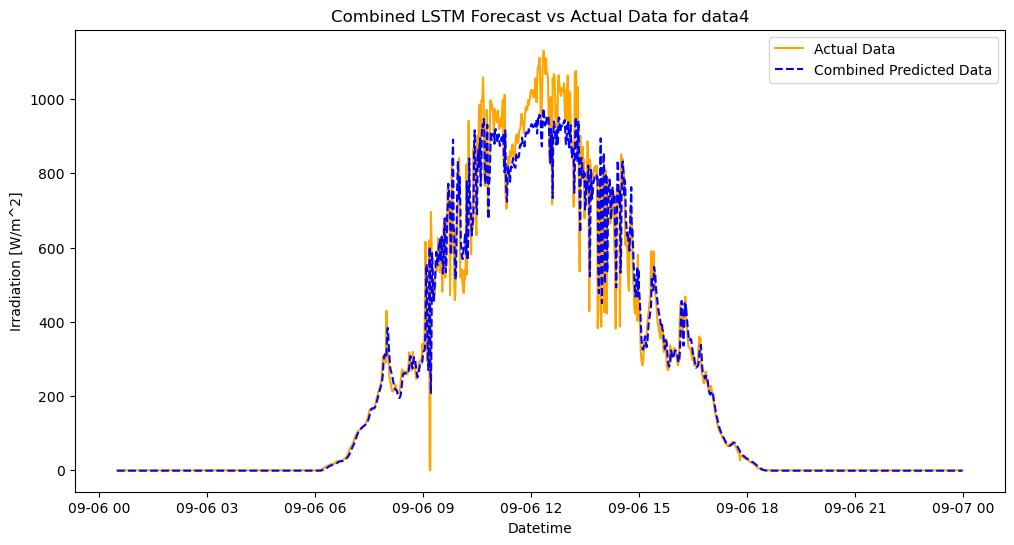

In [2]:
# The multiple model 230924 has been updated to incorporate the actual data from the farm. 
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Function to create LSTM dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# # Old Function to build and compile an LSTM model
# def build_lstm_model(time_step):
#     model = Sequential()
#     model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(100))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# Function to build and compile a modified LSTM model
def build_lstm_model(time_step):
    model = Sequential()

    # First LSTM layer with more units and return sequences to allow stacking
    model.add(LSTM(150, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.15))  # Slightly reduced dropout

    # Second LSTM layer with more units and return sequences
    model.add(LSTM(150, return_sequences=True))
    model.add(Dropout(0.15))  # Slightly reduced dropout

    # Third LSTM layer without return_sequences
    model.add(LSTM(100))
    model.add(Dropout(0.1))  # Reduced dropout

    # Dense output layer
    model.add(Dense(1))

    # Compile with a smaller learning rate for finer optimization
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


# Step 2: Prepare the data
# Now we will preprocess the four datasets and normalize them using MinMaxScaler.

# Load datasets
# data1 = pd.read_csv('texas_110924.csv')
# data2 = pd.read_csv('texas_120924.csv')
# data3 = pd.read_csv('texas_300824.csv')
# data4 = pd.read_csv('texas_80924.csv')
# Load datasets: BCP
data1 = pd.read_csv('BPI 2024-09-01.csv')
data2 = pd.read_csv('BPI 2024-09-02.csv')
data3 = pd.read_csv('BPI 2024-09-03.csv')
# data3 = pd.read_csv('BPI 2024-09-05.csv')
# data3 = pd.read_csv('BPI 2024-09-14.csv')
data4 = pd.read_csv('BPI 2024-09-04.csv')
data5 = pd.read_csv('BPI 2024-09-06.csv')



# Data preparation function to preprocess data (same steps for all datasets)
# def preprocess_data(df):
#     df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
#     df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time
#     df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)
#     df.set_index('Datetime', inplace=True)
#     df = df[['Global Horizontal [W/m^2]']].dropna()
#     return df

# Data preparation function to preprocess data (same steps for all datasets)
def preprocess_data_BCP(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
    df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
    df.set_index('Datetime', inplace=True)
    df = df[['Irradiation']].dropna()
    return df
    
# Preprocess all datasets
# df1 = preprocess_data(data1)
# df2 = preprocess_data(data2)
# df3 = preprocess_data(data3)
# df4 = preprocess_data(data4)

df1 = preprocess_data_BCP(data1)
df2 = preprocess_data_BCP(data2)
df3 = preprocess_data_BCP(data3)
df4 = preprocess_data_BCP(data4)
df5 = preprocess_data_BCP(data5)
# Normalize the data using MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 5))  # Use (0,2) for spike curves

# scaler = MinMaxScaler(feature_range=(0, 2))  # Use (0,2) for flat curves
# scaler = MinMaxScaler(feature_range=(0, 1))  # Use (0,2) for flat curves
# scaler = MinMaxScaler(feature_range=(0, 0.1))  # Use (0,2) for flat curves
scaler = MinMaxScaler(feature_range=(0, 10))  # Use (0,10) for flat curves

scaled_data1 = scaler.fit_transform(df1.values)
scaled_data2 = scaler.fit_transform(df2.values)
scaled_data3 = scaler.fit_transform(df3.values)
scaled_data4 = scaler.fit_transform(df4.values)
scaled_data5 = scaler.transform(df5.values)  # We only transform data5 since we already fitted the scaler

# Step 3: Create and train models on each dataset
# For each dataset (data1, data2, and data3), we will create an LSTM model, train it, and store the trained models.

time_step = 30  # or another suitable value
models = []

# Train model on data1
X1, y1 = create_dataset(scaled_data1, time_step)
X1 = X1.reshape(X1.shape[0], X1.shape[1], 1)
model1 = build_lstm_model(time_step)
history1 = model1.fit(X1, y1, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model1)

# Train model on data2
X2, y2 = create_dataset(scaled_data2, time_step)
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)
model2 = build_lstm_model(time_step)
history2 = model2.fit(X2, y2, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model2)

# Train model on data3
X3, y3 = create_dataset(scaled_data3, time_step)
X3 = X3.reshape(X3.shape[0], X3.shape[1], 1)
model3 = build_lstm_model(time_step)
history3 = model3.fit(X3, y3, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model3)

# Train model on data3
X4, y4 = create_dataset(scaled_data4, time_step)
X4 = X4.reshape(X4.shape[0], X4.shape[1], 1)
model4 = build_lstm_model(time_step)
history4 = model4.fit(X4, y4, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model4)


# Step 4: Forecast for data4 using each model and combine predictions
# After training the models, we will use each model to predict the values for data4. Finally, we will combine the predictions from all models (e.g., using averaging).

# # Prepare dataset for forecasting (data4)
# X4, y4 = create_dataset(scaled_data4, time_step)
# Prepare dataset for forecasting (data4)


X5, y5 = create_dataset(scaled_data5, time_step)

# X4 = X4.reshape(X4.shape[0], X4.shape[1], 1)
X5 = X5.reshape(X5.shape[0], X5.shape[1], 1)

# Predict the test set results for data4 using each model
predictions = []

for model in models:
    # pred = model.predict(X4)
    pred = model.predict(X5)
    predictions.append(pred)

# Combine predictions from all models (e.g., using averaging)
predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

# Rescale the predictions back to the original scale
combined_predictions_rescaled = scaler.inverse_transform(combined_predictions)
# y4_rescaled = scaler.inverse_transform(y4.reshape(-1, 1))
y5_rescaled = scaler.inverse_transform(y5.reshape(-1, 1))

# Step 5: Calculate error metrics (MAPE and MSE)
# Assume y5_rescaled contains the actual values and combined_predictions_rescaled contains the predicted values.
# Set a threshold to filter out zero or near-zero values.
threshold = 20  # You can adjust this threshold based on your data.

# Filter out zero or near-zero values.
non_zero_indices = np.where(y5_rescaled > threshold)

# Use the filtered indices to compute MSE and MAPE only for non-zero values.
y5_non_zero = y5_rescaled[non_zero_indices]
predictions_non_zero = combined_predictions_rescaled[non_zero_indices]

# Compute MSE only for non-zero values
mse = mean_squared_error(y5_non_zero, predictions_non_zero)

# Compute MAPE only for non-zero values
mape = np.mean(np.abs((y5_non_zero - predictions_non_zero) / y5_non_zero)) * 100

print(f"MSE: {mse}")
print(f"MAPE: {mape}%")

# print(f'MAPE: {mape * 100:.2f}%')
# print(f'MSE: {mse:.4f}')

# Plot the actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(df4.index[time_step:], y4_rescaled, color='orange', label='Actual Data')
# plt.plot(df4.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Combined Predicted Data')
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df5.index[time_step:], y5_rescaled, color='orange', label='Actual Data')
plt.plot(df5.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Combined Predicted Data')

plt.title('Combined LSTM Forecast vs Actual Data for data4')
plt.xlabel('Datetime')
# plt.ylabel('Global Horizontal [W/m^2]')
plt.ylabel('Irradiation [W/m^2]')
plt.legend()
plt.show()


45/45 [==============================] - 1s 23ms/step
1-Minute MAPE: 13.61%


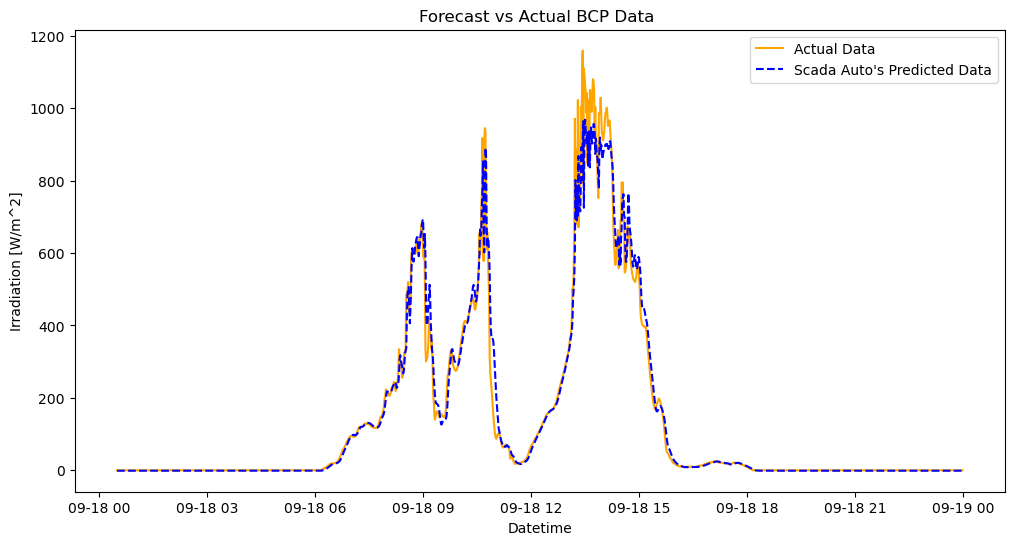

In [9]:
# data4 = pd.read_csv('texas.csv')
# data4 = pd.read_csv('texas_150924.csv')
# data4 = pd.read_csv('texas_110924.csv')
# data4 = pd.read_csv('texas_120924.csv')
# data4 = pd.read_csv('texas_130924.csv')
# data4 = pd.read_csv('texas_70924.csv')
# data4 = pd.read_csv('texas_60924.csv')
# data4 = pd.read_csv('texas_50924.csv')
# data4 = pd.read_csv('texas_40924.csv')
# data4 = pd.read_csv('texas_30924.csv')
# data4 = pd.read_csv('texas_20924.csv')
# data4 = pd.read_csv('texas_10924.csv')
# data4 = pd.read_csv('texas_310824.csv')

# data4 = pd.read_csv('BPI 2024-09-06.csv')
# data4 = pd.read_csv('BPI 2024-09-01.csv')
# data4 = pd.read_csv('BPI 2024-09-02.csv')
# data4 = pd.read_csv('BPI 2024-09-07.csv')
# data5 = pd.read_csv('BPI 2024-09-03.csv')
# data5 = pd.read_csv('BPI 2024-09-08.csv')
# data5 = pd.read_csv('BPI 2024-09-09.csv')
# data5 = pd.read_csv('BPI 2024-09-10.csv')
# data5 = pd.read_csv('BPI 2024-09-11.csv')
# data5 = pd.read_csv('BPI 2024-09-12.csv')
# data5 = pd.read_csv('BPI 2024-09-13.csv')
# data5 = pd.read_csv('BPI 2024-09-14.csv')
# data5 = pd.read_csv('BPI 2024-09-15.csv')
# data5 = pd.read_csv('BPI 2024-09-16.csv')
# data5 = pd.read_csv('BPI 2024-09-17.csv')
data5 = pd.read_csv('BPI 2024-09-18.csv')
# data5 = pd.read_csv('BPI 2024-09-19.csv')

# data5 = pd.read_csv('BPI 2024-09-07.csv')
# data5 = pd.read_csv('BPI 2024-09-05.csv')


df5 = preprocess_data_BCP(data5)
scaled_data5 = scaler.transform(df5.values)  # We only transform data4 since we already fitted the scaler



# Prepare dataset for forecasting (data5)
X5, y5 = create_dataset(scaled_data5, time_step)
X5 = X5.reshape(X5.shape[0], X5.shape[1], 1)

# Predict the test set results for data4 using each model
predictions = []

for model in models:
    # pred = model.predict(X4)
    pred = model.predict(X5)
    predictions.append(pred)

# Combine predictions from all models (e.g., using averaging)
predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

# Rescale the predictions back to the original scale
combined_predictions_rescaled = scaler.inverse_transform(combined_predictions)
y5_rescaled = scaler.inverse_transform(y5.reshape(-1, 1))


# Step 5: Calculate error metrics (MAPE and MSE)
# Assume y5_rescaled contains the actual values and combined_predictions_rescaled contains the predicted values.
# Set a threshold to filter out zero or near-zero values.
threshold = 10  # You can adjust this threshold based on your data.

# Filter out zero or near-zero values.
non_zero_indices = np.where(y5_rescaled > threshold)

# Use the filtered indices to compute MSE and MAPE only for non-zero values.
y5_non_zero = y5_rescaled[non_zero_indices]
predictions_non_zero = combined_predictions_rescaled[non_zero_indices]

# Compute MSE only for non-zero values
mse = mean_squared_error(y5_non_zero, predictions_non_zero)

# Compute MAPE only for non-zero values
mape = np.mean(np.abs((y5_non_zero - predictions_non_zero) / y5_non_zero)) * 100

# Step 5: Calculate error metrics (MAPE and MSE)

# print(f"MSE: {mse}")
# print(f"MAPE: {mape}%")
# print(f'MAPE: {mape:.2f}%')
print(f"1-Minute MAPE: {mape:.2f}%")
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
# plt.plot(df4.index[time_step:], y4_rescaled, color='orange', label='Actual Data')
# plt.plot(df4.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Scada Auto\'s Predicted Data')
plt.plot(df5.index[time_step:], y5_rescaled, color='orange', label='Actual Data')
plt.plot(df5.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Scada Auto\'s Predicted Data')
plt.title('Forecast vs Actual BCP Data ')
plt.xlabel('Datetime')
plt.ylabel('Irradiation [W/m^2]')
plt.legend()
plt.show()

In [7]:
# Ensure that the index is in datetime format
df5.index = pd.to_datetime(df5.index)

# Resample the actual and predicted values to 15-minute frequency by averaging
y5_rescaled_df = pd.DataFrame(y5_rescaled, index=df5.index[time_step:], columns=['Irradiation'])
combined_predictions_rescaled_df = pd.DataFrame(combined_predictions_rescaled, index=df5.index[time_step:], columns=['Predicted'])

# Resample the data to 15-minute averages
y5_rescaled_15min = y5_rescaled_df.resample('15min').mean().values
combined_predictions_rescaled_15min = combined_predictions_rescaled_df.resample('15min').mean().values

# Set a threshold to filter out zero or near-zero values
threshold = 10  # You can adjust this threshold based on your data.

# Filter out zero or near-zero values for 15-minute resampled data
non_zero_indices = np.where(y5_rescaled_15min > threshold)

# Use the filtered indices to compute MSE and MAPE only for non-zero values
y5_non_zero_15min = y5_rescaled_15min[non_zero_indices]
predictions_non_zero_15min = combined_predictions_rescaled_15min[non_zero_indices]

# Compute MSE only for non-zero 15-minute values
mse_15min = mean_squared_error(y5_non_zero_15min, predictions_non_zero_15min)

# Compute MAPE only for non-zero 15-minute values
mape_15min = np.mean(np.abs((y5_non_zero_15min - predictions_non_zero_15min) / y5_non_zero_15min)) * 100

# Print the MAPE and MSE for 15-minute data
# print(f"15-Minute MSE: {mse_15min}")
print(f"15-Minute MAPE: {mape_15min:.2f}%")

15-Minute MAPE: 11.36%


In [8]:
# Assuming df5.index contains the datetime information
# Ensure that the index is in datetime format
# Ensure that the index is in datetime format
df5.index = pd.to_datetime(df5.index)

# Resample the actual and predicted values to hourly frequency by averaging
y5_rescaled_df = pd.DataFrame(y5_rescaled, index=df5.index[time_step:], columns=['Irradiation'])
combined_predictions_rescaled_df = pd.DataFrame(combined_predictions_rescaled, index=df5.index[time_step:], columns=['Predicted'])

# Resample the data to hourly averages
y5_rescaled_hourly = y5_rescaled_df.resample('h').mean().values
combined_predictions_rescaled_hourly = combined_predictions_rescaled_df.resample('h').mean().values

# Set a threshold to filter out zero or near-zero values
threshold = 10  # You can adjust this threshold based on your data.

# Filter out zero or near-zero values for hourly resampled data
non_zero_indices = np.where(y5_rescaled_hourly > threshold)

# Use the filtered indices to compute MSE and MAPE only for non-zero values
y5_non_zero_hourly = y5_rescaled_hourly[non_zero_indices]
predictions_non_zero_hourly = combined_predictions_rescaled_hourly[non_zero_indices]

# Compute MSE only for non-zero hourly values
mse_hourly = mean_squared_error(y5_non_zero_hourly, predictions_non_zero_hourly)

# Compute MAPE only for non-zero hourly values
mape_hourly = np.mean(np.abs((y5_non_zero_hourly - predictions_non_zero_hourly) / y5_non_zero_hourly)) * 100

# Print the MAPE and MSE for hourly data
# print(f"Hourly MSE: {mse_hourly}")
print(f"Hourly MAPE: {mape_hourly:.2f}%")

# # Plot the actual vs predicted values for hourly data
# plt.figure(figsize=(12, 6))
# plt.plot(y5_rescaled_df.resample('h').mean().index, y5_rescaled_hourly, color='orange', label='Actual Data (Hourly)')
# plt.plot(combined_predictions_rescaled_df.resample('h').mean().index, combined_predictions_rescaled_hourly, color='blue', linestyle='--', label='Predicted Data (Hourly)')
# plt.title('Forecast vs Actual BCP Data (Hourly)')
# plt.xlabel('Datetime')
# plt.ylabel('Irradiation [W/m^2]')
# plt.legend()
# plt.show()

Hourly MAPE: 7.57%


In [97]:
print(f"Hourly MSE: {mse_hourly}")

Hourly MSE: 1058.2433448808376


In [98]:
print(f"15-Minute MSE: {mse_15min}")


15-Minute MSE: 1878.8402658825055
